In [25]:
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.distributions import Categorical, OneHotCategorical
from matplotlib import pyplot as plt
from unet import UNet
from tqdm import tqdm
import numpy as np
from difflib import SequenceMatcher
device='cuda' if torch.cuda.is_available() else 'cpu'
from unet import UNet

from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

In [26]:
mnist_data = torch.tensor(np.load('data/binary_mnist.npy'))
length = mnist_data.shape[0]
mnist_data = mnist_data.view(length*784)

# torch data
out = torch.zeros(length*784,2, dtype=torch.float32)
out[mnist_data==0, 0]=1
out[mnist_data==1, 1]=1
mnist_data = out.view(length, 28, 28, 2).permute((0,3,1,2))


dataset = TensorDataset(mnist_data) 
dataloader = DataLoader(dataset, batch_size=500, shuffle=True) # create your dataloader

In [3]:
def closest(out):
    return mnist_data[(((mnist_data-out.to('cpu'))**2).sum((1,2,3))).argmin()]

def cust_show(out,**kwargs):
    plt.imshow(out.cpu().detach().numpy(), **kwargs)
    plt.show()



In [4]:

class AODM(nn.Module):
    def __init__(self, h=28, w=28, k=2, lr=1e-4):
        super().__init__()
        self.h, self.w, self.k = h, w, k
        self.d = self.h * self.w
        self.unet = UNet(2,2)
        self.lr = lr

    def forward(self, x):
        x_ = self.unet(x)
        return torch.log_softmax(x_, dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d + 1, (N, 1, 1), device=device)

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d, device=device).reshape(self.h, self.w) + 1 for _ in range(N)])

    def sigma_with_mask(self, mask):
        # sigma = [1.. mask_pixels || randperm (remaining pixels) ]
        sigma = torch.zeros((1, self.h, self.w), dtype=torch.long, device=device)
        sigma[mask] = torch.arange(mask.sum()) + 1
        sigma[~mask] = torch.randperm(self.d - mask.sum(), device=device) + mask.sum()
        return sigma

    def training_step(self, x):
        N, K, H, W = x.shape
        t = self.sample_t(N)
        sigma = self.sample_sigma(N)
        mask = sigma < t
        mask = mask.unsqueeze(1).float()
        x_ = self(x * mask)
        C = Categorical(logits=x_.permute(0, 2, 3, 1))
        l = (1. - mask) * C.log_prob(torch.argmax(x, dim=1)).unsqueeze(1)
        n = 1. / (self.d - t + 1.)
        l = n * l.sum(dim=(1, 2, 3))
        return {'loss': -l.mean(), 'input': x.detach(), 'generated': x_.detach()}

    def training_step_end(self, o):
        self.log('loss', o['loss'])

    def validation_step(self, *args, **kwargs):
        sample = self.sample_one()
        self.sample_quality(sample)
        return {'sample': sample.cpu()}

    def validation_epoch_end(self, outputs):
        self.log('sample_quality', self.sample_quality.compute())

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [opt]

    def sample_one(self):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_one_seeded(self, x_seed, mask):

        # add masked pixels to seed
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        x[mask] = x_seed[mask]
        sigma = self.sigma_with_mask(mask)

        for t in range(mask.sum(), self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_step(self, x, t, sigma):
        """
        Performs one step of the noise reversal transition function in order sigma at time t
        x: the current state
        t: the current timestep
        sigma: the order
        """
        past, current = sigma < t, sigma == t
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x

In [5]:
model = AODM().to(device)
#model.eval()
#out = model.sample_one()
model = torch.load('mnist_trained.pt')
opt = model.configure_optimizers()[0]
L=[]

In [6]:
model.lr = 1e-5
opt = model.configure_optimizers()[0]

In [7]:
for i in tqdm(range(40)):
   # model.eval()
    #out = model.sample_one()
    #plt.imsave('figs/epoch_{}.png'.format(i), out[0,1].cpu().detach().numpy())


    model.train()
    l=0
    for idx, batch in enumerate(dataloader):
        x = batch[0].to(device)
        opt.zero_grad()
        out = model.training_step(x)
        loss = out['loss']
        l+=loss.item()
        loss.backward()
        opt.step()
    L.append(l)
   

 28%|███████████▊                               | 11/40 [06:34<17:20, 35.87s/it]


KeyboardInterrupt: 

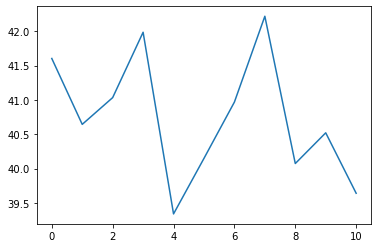

In [8]:
plt.plot(L)

In [17]:
!zip -r figs.zip  figs

updating: figs/ (stored 0%)
updating: figs/overfit/ (stored 0%)
updating: figs/overfit/.ipynb_checkpoints/ (stored 0%)
updating: figs/overfit/2_gen.png (stored 0%)
updating: figs/overfit/2_ref.png (stored 0%)
updating: figs/overfit/1_gen.png (stored 0%)
updating: figs/overfit/1_ref.png (stored 0%)
updating: figs/overfit/3_gen.png (stored 0%)
updating: figs/overfit/3_ref.png (stored 0%)
updating: figs/overfit/4_gen.png (stored 0%)
updating: figs/overfit/4_ref.png (stored 0%)
updating: figs/overfit/5_gen.png (stored 0%)
updating: figs/overfit/5_ref.png (stored 0%)
updating: figs/overfit/6_gen.png (stored 0%)
updating: figs/overfit/6_ref.png (stored 0%)
updating: figs/overfit/7_gen.png (stored 0%)
updating: figs/overfit/7_ref.png (stored 0%)
updating: figs/overfit/8_gen.png (stored 0%)
updating: figs/overfit/8_ref.png (stored 0%)
updating: figs/overfit/9_gen.png (stored 0%)
updating: figs/overfit/9_ref.png (stored 0%)
updating: figs/overfit/10_gen.png (stored 0%)
updating: figs/overfit/10

In [22]:
ind=0

for i in range(1):
    model.eval()
    out = model.sample_one()
    gen_im = out[0,1].cpu().detach().numpy()
    ref_im = closest(out)[1].cpu().detach().numpy()

    ind+=1
    
    gen_im = Image.fromarray(gen_im>0.5)
    gen_im = gen_im.resize((280,280), Image.NEAREST)
   
    ref_im = Image.fromarray(ref_im>0.5)
    ref_im = ref_im.resize((280,280), Image.NEAREST)
    #gen_im.save('figs/overfit/{}_gen.png'.format(ind))
    #ref_im.save('figs/overfit/{}_ref.png'.format(ind))

#gen_im

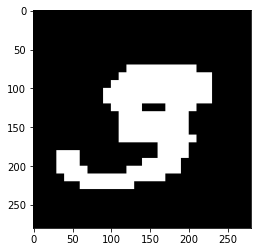

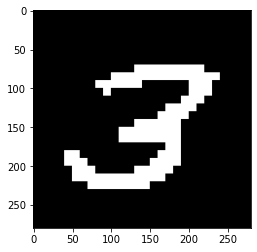

In [23]:
plt.imshow(gen_im, cmap='gray')
plt.show()
plt.imshow(ref_im, cmap='gray')
plt.show()


In [88]:
for i in range(30):
    im = Image.open('figs/epoch_{}.png'.format(i))
    im = im.resize((280,280), Image.NEAREST)
    plt.imsave('figs2/epoch_{}.png'.format(i), np.array(im)[:,:,0]>100, cmap='gray')

In [87]:
np.array(im)[:,:,0].max()

253

In [132]:
Image.open('figs/overfit/1_gen.png')
im = im.resize((280,280), Image.NEAREST)

In [131]:
im.size

(280, 280)

In [145]:
im = Image.fromarray(gen_im>0.5)
im = im.resize((280,280), Image.NEAREST)

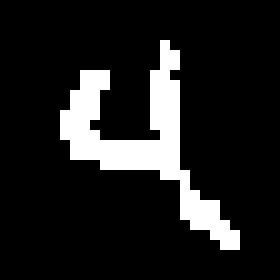

In [146]:
im

In [147]:
im.save('o.png')